In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,AveragePooling2D,AveragePooling3D
from keras.layers import Dense, GlobalAveragePooling3D,GlobalAveragePooling2D, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils, generic_utils, Sequence
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D
import keras

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import preprocessing
import os
save_dir = os.path.join(os.getcwd(),'save_model')

Using TensorFlow backend.


In [2]:
# image specification
img_cols,img_rows=128,128
nb_frames = 64    # img_depth or number of frames used for each video
# CNN Training parameters
nb_classes = 11
channels = 2

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

labels = pd.read_csv('D:/Project/eventbins/DvsGesture/gesture_mapping.csv')
#train
train = pd.read_csv('E:\Jupyter\Project\dvs128train.csv',sep=';',header=None,names=['Video','Label'])     # reading the csv file

#validation
validation = pd.read_csv('E:\Jupyter\Project\dvs128test.csv',sep=';',header=None,names=['Video','Label'])     # reading the csv file

temp = pd.concat([train, validation])
temp = temp.set_index("Video")
#temp = train.set_index("Video")
temp.transpose()
labels_dict = (temp["Label"]-1).to_dict()
len(train)

1176

In [4]:
labels['Label']=labels['label']-1
labels

,action,label,Label
0,hand_clapping,1,0
1,right_hand_wave,2,1
2,left_hand_wave,3,2
3,right_arm_clockwise,4,3
4,right_arm_counter_clockwise,5,4
5,left_arm_clockwise,6,5
6,left_arm_counter_clockwise,7,6
7,arm_roll,8,7
8,air_drums,9,8
9,air_guitar,10,9


In [6]:
import random
def data_gen(train_list, batch_size=64):
    while True:
        current_vid=0
        X_tr_array = np.zeros([batch_size,nb_frames,img_cols,img_rows,channels])
        Y_train = np.zeros([batch_size, nb_classes])
        for vid_ID in random.sample(train_list,batch_size):
            frame_count=0
            pos_dir = os.path.join("E:/Jupyter/Project/dvs_generated/pos",str(vid_ID))
            neg_dir = os.path.join("E:/Jupyter/Project/dvs_generated/neg",str(vid_ID))
            for img_ID in sorted(os.listdir(pos_dir)):
                pos = os.path.join(pos_dir,img_ID)
                neg = os.path.join(neg_dir,img_ID)
                p_img = cv2.imread(pos,0)
                X_tr_array[current_vid,frame_count,:,:,0]=p_img
                n_img = cv2.imread(neg,0)
                X_tr_array[current_vid,frame_count,:,:,1]=n_img
                #frame = cv2.merge((p_img,n_img))
                #X_tr_array[current_vid,frame_count]=frame
                frame_count+=1
            Y_train[current_vid]=np_utils.to_categorical(labels_dict[vid_ID]-1, nb_classes)
            current_vid+=1

        yield X_tr_array,Y_train

In [5]:
from keras.models import Model, load_model
model1_name = "deeper_full"
model1_path = os.path.join(save_dir, model1_name)
model1 = load_model(model1_path)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling3d_1 (MaxPooling3 (None, 64, 50, 88, 2)     0         
_________________________________________________________________
Conv_spatial_1 (Conv3D)      (None, 64, 46, 84, 16)    816       
_________________________________________________________________
Conv_spatial_12 (Conv3D)     (None, 64, 44, 82, 16)    2320      
_________________________________________________________________
Conv_spatial_13 (Conv3D)     (None, 64, 44, 82, 16)    272       
_________________________________________________________________
Conv_temporal_1 (Conv3D)     (None, 60, 44, 82, 16)    1296      
_________________________________________________________________
MaxPool_1 (MaxPooling3D)     (None, 60, 22, 41, 16)    0         
_________________________________________________________________
Conv_spatial_2 (Conv3D)      (None, 60, 18, 37, 64)    25664     
__________

In [6]:
# Define model
import tensorflow as tf
keras=tf.contrib.keras
l2=keras.regularizers.l2
weight_decay = 0.00005
from keras import regularizers

model = Sequential()
model.add(MaxPooling3D(pool_size=(1, 2, 2),input_shape=(nb_frames,  img_cols, img_rows, channels)))

model.add(Conv3D(16,(1,5,5),activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_spatial_1'))
model.add(Conv3D(16,(1,3,3),activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_spatial_12'))
model.add(Conv3D(16,(1,1,1),activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_spatial_13'))
model.add(Conv3D(16,(5,1,1),activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_temporal_1'))
model.add(MaxPooling3D(pool_size=(1, 2, 2), name='MaxPool_1'))

model.add(Conv3D(64,(1,5,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_spatial_2'))
model.add(Conv3D(64,(1,3,3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_spatial_22'))
model.add(Conv3D(64,(1,1,1),activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_spatial_23'))
model.add(Conv3D(64,(3,1,1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_temporal_2'))
model.add(MaxPooling3D(pool_size=(1, 2, 2), name='MaxPool_2'))

model.add(Conv3D(128,(1,5,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_spatial_3'))
model.add(Conv3D(128,(1,3,3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_spatial_32'))
model.add(Conv3D(128,(1,1,1),activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_spatial_33'))
model.add(Conv3D(128,(3,1,1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='Conv_temporal_3'))
model.add(MaxPooling3D(pool_size=(1, 2, 2), name='MaxPool_3'))

model.add(ConvLSTM2D(filters=128, kernel_size=(3,3),
                     strides=(1,1),padding='same',
                     kernel_initializer='he_normal', recurrent_initializer='he_normal',
                     kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                     return_sequences=True, name='LSTM_1'))
model.add(ConvLSTM2D(filters=128, kernel_size=(3,3),
                     strides=(1,1),padding='same',
                     kernel_initializer='he_normal', recurrent_initializer='he_normal',
                     kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                     return_sequences=True, name='LSTM_2'))
model.add(ConvLSTM2D(filters=128, kernel_size=(3,3),
                     strides=(1,1),padding='same',
                     kernel_initializer='he_normal', recurrent_initializer='he_normal',
                     kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                     return_sequences=True, name='LSTM_3'))

model.add(Flatten(name='Flatten'))
model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='FC_1'))
model.add(Dropout(0.5, name='Dropout_1'))

model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(weight_decay), name='FC_2'))
model.add(Dropout(0.5, name='Dropout_2'))

model.add(Dense(nb_classes,kernel_initializer='normal',kernel_regularizer=regularizers.l2(weight_decay), name='FC_3'))

model.add(Activation('softmax'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling3d_1 (MaxPooling3 (None, 64, 64, 64, 2)     0         
_________________________________________________________________
Conv_spatial_1 (Conv3D)      (None, 64, 60, 60, 16)    816       
_________________________________________________________________
Conv_spatial_12 (Conv3D)     (None, 64, 58, 58, 16)    2320      
_________________________________________________________________
Conv_spatial_13 (Conv3D)     (None, 64, 58, 58, 16)    272       
_________________________________________________________________
Conv_temporal_1 (Conv3D)     (None, 60, 58, 58, 16)    1296      
_________________________________________________________________
MaxPool_1 (MaxPooling3D)     (None, 60, 29, 29, 16)    0         
_________________________________________________________________
Conv_spatial_2 (Conv3D)      (None, 60, 25, 25, 64)    25664     
__________

In [8]:
model.layers[2].set_weights(model1.layers[2].get_weights())
model.layers[3].set_weights(model1.layers[3].get_weights())
model.layers[4].set_weights(model1.layers[4].get_weights())
model.layers[5].set_weights(model1.layers[5].get_weights())
model.layers[7].set_weights(model1.layers[7].get_weights())
model.layers[8].set_weights(model1.layers[8].get_weights())
model.layers[9].set_weights(model1.layers[9].get_weights())
model.layers[10].set_weights(model1.layers[10].get_weights())
model.layers[11].set_weights(model1.layers[11].get_weights())
model.layers[12].set_weights(model1.layers[12].get_weights())
model.layers[13].set_weights(model1.layers[13].get_weights())
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling3d_1 (MaxPooling3 (None, 64, 64, 64, 2)     0         
_________________________________________________________________
Conv_spatial_1 (Conv3D)      (None, 64, 60, 60, 16)    816       
_________________________________________________________________
Conv_spatial_12 (Conv3D)     (None, 64, 58, 58, 16)    2320      
_________________________________________________________________
Conv_spatial_13 (Conv3D)     (None, 64, 58, 58, 16)    272       
_________________________________________________________________
Conv_temporal_1 (Conv3D)     (None, 60, 58, 58, 16)    1296      
_________________________________________________________________
MaxPool_1 (MaxPooling3D)     (None, 60, 29, 29, 16)    0         
_________________________________________________________________
Conv_spatial_2 (Conv3D)      (None, 60, 25, 25, 64)    25664     
__________

In [9]:
import os
save_dir = os.path.join(os.getcwd(),'save_model')
print(os.getcwd())
model_name = "dvs"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_acc', 
                            save_best_only=True, verbose=1)
#earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose =1)

E:\Jupyter\Project


In [10]:
sgd = SGD(lr=0.002,  momentum=0.9, nesterov=False)
rms = RMSprop(decay=1e-6)
ada = Adadelta(lr=0.1,decay=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              #optimizer=ada,
              #optimizer = Adam(lr=0.0001),
              metrics=['acc'])

In [11]:
nb_epoch = 100
batch_size = 16
#steps_per_epoch=int((len(X_val_new)*1.5)/batch_size)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.05, 
                               cooldown=0, patience=7, min_lr=0.005/(2^4),verbose=1)
hist = model.fit_generator(data_gen(train["Video"].tolist()[0:],batch_size),
                           validation_data=data_gen(validation["Video"].tolist()[0:],batch_size),
                           steps_per_epoch=len(train["Video"].tolist()[0:])//(batch_size),
                           validation_steps=len(validation["Video"].tolist()[0:])//(batch_size),
                           epochs = nb_epoch,
                           callbacks=[checkpoint,lr_reducer]
                          )

Epoch 1/100
73/73 [==============================] - 160s 2s/step - loss: 2.4471 - acc: 0.2723 - val_loss: 1.9440 - val_acc: 0.4236

Epoch 00001: val_acc improved from -inf to 0.42361, saving model to E:\Jupyter\Project\save_model\dvs
Epoch 2/100
73/73 [==============================] - 149s 2s/step - loss: 1.8631 - acc: 0.4426 - val_loss: 1.8465 - val_acc: 0.4340

Epoch 00002: val_acc improved from 0.42361 to 0.43403, saving model to E:\Jupyter\Project\save_model\dvs
Epoch 3/100
73/73 [==============================] - 148s 2s/step - loss: 1.6056 - acc: 0.5428 - val_loss: 1.5275 - val_acc: 0.5625

Epoch 00003: val_acc improved from 0.43403 to 0.56250, saving model to E:\Jupyter\Project\save_model\dvs
Epoch 4/100
73/73 [==============================] - 146s 2s/step - loss: 1.4663 - acc: 0.6053 - val_loss: 1.5112 - val_acc: 0.5799

Epoch 00004: val_acc improved from 0.56250 to 0.57986, saving model to E:\Jupyter\Project\save_model\dvs
Epoch 5/100
73/73 [==============================] 


Epoch 00081: val_acc did not improve from 0.93750
Epoch 82/100
73/73 [==============================] - 149s 2s/step - loss: 0.4157 - acc: 1.0000 - val_loss: 0.9357 - val_acc: 0.9340

Epoch 00082: val_acc did not improve from 0.93750
Epoch 83/100
73/73 [==============================] - 153s 2s/step - loss: 0.4160 - acc: 1.0000 - val_loss: 1.2290 - val_acc: 0.8854

Epoch 00083: val_acc did not improve from 0.93750
Epoch 84/100
73/73 [==============================] - 157s 2s/step - loss: 0.4157 - acc: 1.0000 - val_loss: 1.0994 - val_acc: 0.9028

Epoch 00084: val_acc did not improve from 0.93750
Epoch 85/100
73/73 [==============================] - 148s 2s/step - loss: 0.4160 - acc: 1.0000 - val_loss: 1.1728 - val_acc: 0.8785

Epoch 00085: val_acc did not improve from 0.93750
Epoch 86/100
73/73 [==============================] - 147s 2s/step - loss: 0.4154 - acc: 1.0000 - val_loss: 1.1208 - val_acc: 0.9028

Epoch 00086: val_acc did not improve from 0.93750

Epoch 00086: ReduceLROnPlate

In [12]:
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']
training_acc = hist.history['acc']
val_acc = hist.history['val_acc']

In [13]:
"""for entry in hist1.history['loss']:
    training_loss.append(entry)
for entry in hist1.history['val_loss']:
    val_loss.append(entry)
for entry in hist1.history['acc']:
    training_acc.append(entry)
for entry in hist1.history['val_acc']:
    val_acc.append(entry)"""

"for entry in hist1.history['loss']:\n    training_loss.append(entry)\nfor entry in hist1.history['val_loss']:\n    val_loss.append(entry)\nfor entry in hist1.history['acc']:\n    training_acc.append(entry)\nfor entry in hist1.history['val_acc']:\n    val_acc.append(entry)"

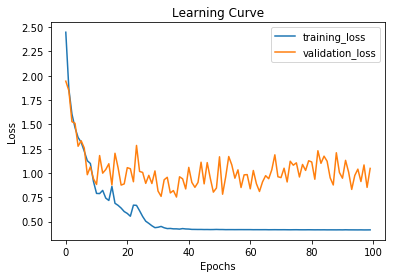

"with open('deeploss_tr.pkl','rb') as fid:\n    training_loss = pickle.load(fid)"

In [14]:
import pickle
with open('deeploss_tr.pkl','rb') as fid:
    training_loss = pickle.load(fid)"
    plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

with open('E:/Jupyter/Project/save_model/dvs_loss.pkl','wb') as fid:
    pickle.dump(training_loss, fid)
with open('E:/Jupyter/Project/save_model/dvs_loss_val.pkl','wb') as fid:
    pickle.dump(val_loss, fid)
"""with open('deeploss_tr.pkl','rb') as fid:
    training_loss = pickle.load(fid)"""

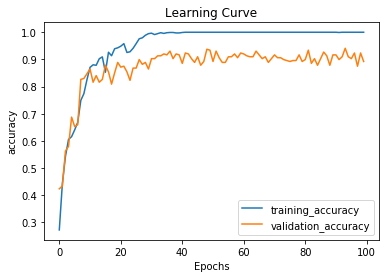

In [15]:

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

with open('E:/Jupyter/Project/save_model/dvs_acc.pkl','wb') as fid:
    pickle.dump(training_acc, fid)
with open('E:/Jupyter/Project/save_model/dvs_acc_val.pkl','wb') as fid:
    pickle.dump(val_acc, fid)

In [5]:
from keras.models import Model, load_model
model1_name = "dvs"
model1_path = os.path.join(save_dir, model1_name)
model1 = load_model(model1_path)

In [23]:
model1.evaluate_generator(data_gen(validation["Video"].tolist()[0:],batch_size),
                         len(validation["Video"].tolist()[0:])//(batch_size))

[1.0562207169002957, 0.8993055555555556]

In [22]:
model.evaluate_generator(data_gen(validation["Video"].tolist()[0:],batch_size),
                         len(validation["Video"].tolist()[0:])//(batch_size))

[1.0093465480539534, 0.9131944444444444]

In [19]:
from keras.models import Model, save_model
model1_name = "dvs"
model1_path = os.path.join(save_dir, model1_name)
#save_model(model,model1_path)

In [6]:
def data_predict_gen(train_list, niter, batch_size=64):
    while True:
        current_vid=0
        X_tr_array = np.zeros([batch_size,nb_frames,img_cols,img_rows,channels])
        Y_train = np.zeros([batch_size, nb_classes])
        for vid_ID in train_list[niter*batch_size:(niter+1)*batch_size]:
            frame_count=0
            pos_dir = os.path.join("E:/Jupyter/Project/dvs_generated/pos",str(vid_ID))
            neg_dir = os.path.join("E:/Jupyter/Project/dvs_generated/neg",str(vid_ID))
            for img_ID in sorted(os.listdir(pos_dir)):
                pos = os.path.join(pos_dir,img_ID)
                neg = os.path.join(neg_dir,img_ID)
                p_img = cv2.imread(pos,0)
                X_tr_array[current_vid,frame_count,:,:,0]=p_img
                n_img = cv2.imread(neg,0)
                X_tr_array[current_vid,frame_count,:,:,1]=n_img
                #frame = cv2.merge((p_img,n_img))
                #X_tr_array[current_vid,frame_count]=frame
                frame_count+=1
            Y_train[current_vid]=np_utils.to_categorical(labels_dict[vid_ID], nb_classes)
            current_vid+=1

        yield X_tr_array,Y_train

In [7]:
num_samples = 16
batch_size = 16
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
ls_path = os.path.join("E:/Jupyter/Project/dvs_generated")
met = confusion_matrix([10],[10],labels.sort_values(by=['Label'])['Label'].tolist())
met[10][10]-=1
for n in tqdm(range(len(validation["Video"].tolist()[0:])//(num_samples))):
    current_vid=0
    Y_train = np.zeros([batch_size, nb_classes])
    for vid_ID in validation["Video"].tolist()[n*batch_size:(n+1)*batch_size]:
        Y_train[current_vid]=np_utils.to_categorical(labels_dict[vid_ID], nb_classes)
        current_vid+=1
    met1 = confusion_matrix(np.argmax(Y_train,axis =1), np.argmax(model1.predict_generator(data_predict_gen(validation["Video"].tolist()[0:],n,num_samples),1),axis =1),labels.sort_values(by=['Label'])['Label'].tolist())
    for x in range(met1.shape[0]):
        for y in range(met1.shape[0]):
            met[x][y]=met[x][y]+met1[x][y]
print(met)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [01:11<00:00,  3.57s/it]


[[19  0  0  0  0  0  0  2  1  2  0]
 [ 0 24  0  0  0  0  0  0  0  0  0]
 [ 0  0 23  0  0  0  1  0  0  0  0]
 [ 0  1  0 23  0  0  0  0  0  0  0]
 [ 0  1  0  0 23  0  0  0  0  0  0]
 [ 0  0  0  0  0 24  0  0  0  0  0]
 [ 0  0  0  0  0  0 24  0  0  0  0]
 [ 3  0  0  0  0  0  0 44  0  1  0]
 [ 4  0  0  0  0  0  0  1 16  1  2]
 [ 1  0  0  0  0  0  0  0  1 18  4]
 [ 0  0  0  0  0  0  0  0  0  0 24]]


In [8]:
import pickle
with open('E:/Jupyter/Project/save_model/dvs_scratchconf.pkl','wb') as fid:
    pickle.dump(met, fid)

In [ ]:
import itertools
def confusion_matrix_plot(cm, classes, 
                          title='Full Label Set Normalized Confusion Matrix', 
                          normalize=True, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm *= 100
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=270)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')

In [ ]:
confusion_matrix_plot(met, classes=labels.sort_values(by=['Label'])['action'].tolist())
plt.savefig("fulldvs_scratchconfusion.jpg")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

X_tr_array = np.zeros([1,nb_frames,img_cols,img_rows,channels])
Y_train = np.zeros([1, nb_classes])
vid_ID = 95
frame_count=0
current_vid=0
pos_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/pos",str(vid_ID))
neg_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/neg",str(vid_ID))
for img_ID in sorted(os.listdir(pos_dir)):
    pos = os.path.join(pos_dir,img_ID)
    neg = os.path.join(neg_dir,img_ID)
    p_img = cv2.imread(pos,0)
    X_tr_array[current_vid,frame_count,:,:,0]=p_img
    n_img = cv2.imread(neg,0)
    X_tr_array[current_vid,frame_count,:,:,1]=n_img
    #frame = cv2.merge((p_img,n_img))
    #X_tr_array[current_vid,frame_count]=frame
    frame_count+=1
print(labels_dict[vid_ID])

layer_outputs = [layer.output for layer in model1.layers[:12]]
activation_model = Model(inputs=model1.input, outputs=layer_outputs)
activations=activation_model.predict(X_tr_array[0:1])
fig = plt.figure()

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(X_tr_array[0:1].shape[1]):
    im = plt.imshow(X_tr_array[0:1][0, i, :,:, 0], cmap='viridis')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
if not os.path.exists("E:/Jupyter/Project/deep_activations"):
    os.makedirs("E:/Jupyter/Project/deep_activations")
ani.save("E:/Jupyter/Project/deep_activations/"+'input' + '.mp4')

layer_num = 0
layer_names=[]
for layer in model1.layers[:16]:
    layer_names.append(layer.name)
for layer_name, layer_activation in zip(layer_names, activations):

    fig = plt.figure()

    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    ims = []
    if layer_num<10:
        x=layer_activation.shape[-1]
        if x>32:
            x=32
        for layer_iteration in range(x):
            ims = []
            for i in range(layer_activation.shape[1]):
                im = plt.imshow(layer_activation[0, i, :,:,layer_iteration], cmap='viridis')
                ims.append([im])
            ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                            repeat_delay=1000)
            if not os.path.exists("E:/Jupyter/Project/deep_activations/"+str(layer_num)):
                os.makedirs("E:/Jupyter/Project/deep_activations/"+str(layer_num))
            ani.save("E:/Jupyter/Project/deep_activations/"+str(layer_num) +"/"+layer_name+ 'activation' + str(layer_iteration) + '.mp4')
        layer_num +=1